# Load Dataset from Kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download serenaraju/yawn-eye-dataset-new

Dataset URL: https://www.kaggle.com/datasets/serenaraju/yawn-eye-dataset-new
License(s): unknown
yawn-eye-dataset-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip yawn-eye-dataset-new.zip

Archive:  yawn-eye-dataset-new.zip
replace dataset_new/test/Closed/_107.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset_new/test/Closed/_115.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Exploratory Data Analysis

In [ ]:
# utilise GPU in runtime
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## Class distribution of training and testing set

Image counts per category: {'yawn': 617, 'Open': 617, 'no_yawn': 616, 'Closed': 617}


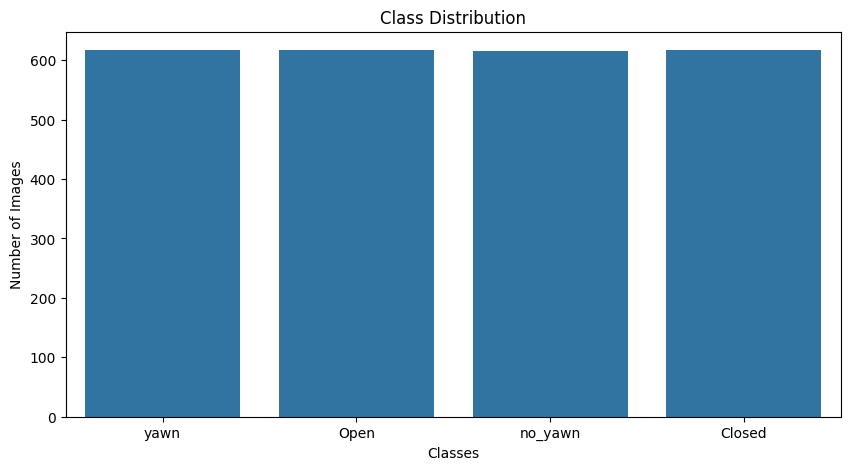

In [ ]:
dataset_path = 'dataset_new/train'

categories = os.listdir(dataset_path)
category_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
print("Image counts per category:", category_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

Image counts per category: {'yawn': 106, 'Open': 109, 'no_yawn': 109, 'Closed': 109}


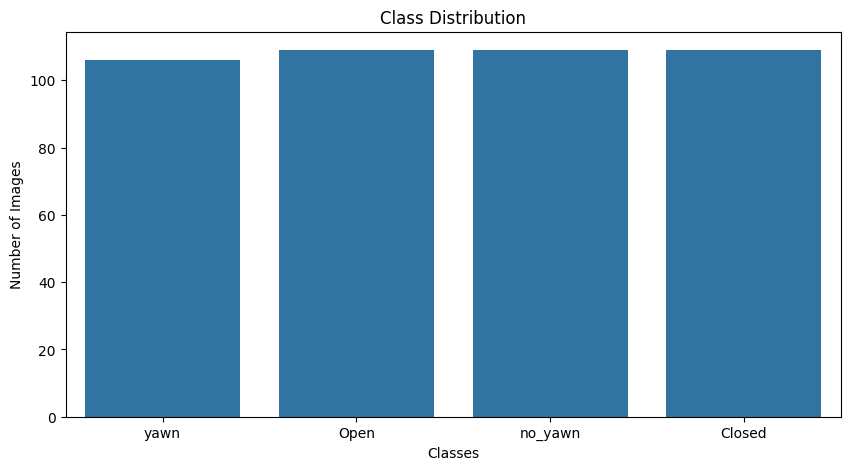

In [ ]:
dataset_path = 'dataset_new/test'

categories = os.listdir(dataset_path)
category_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
print("Image counts per category:", category_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()

## Display 5 random images from each class

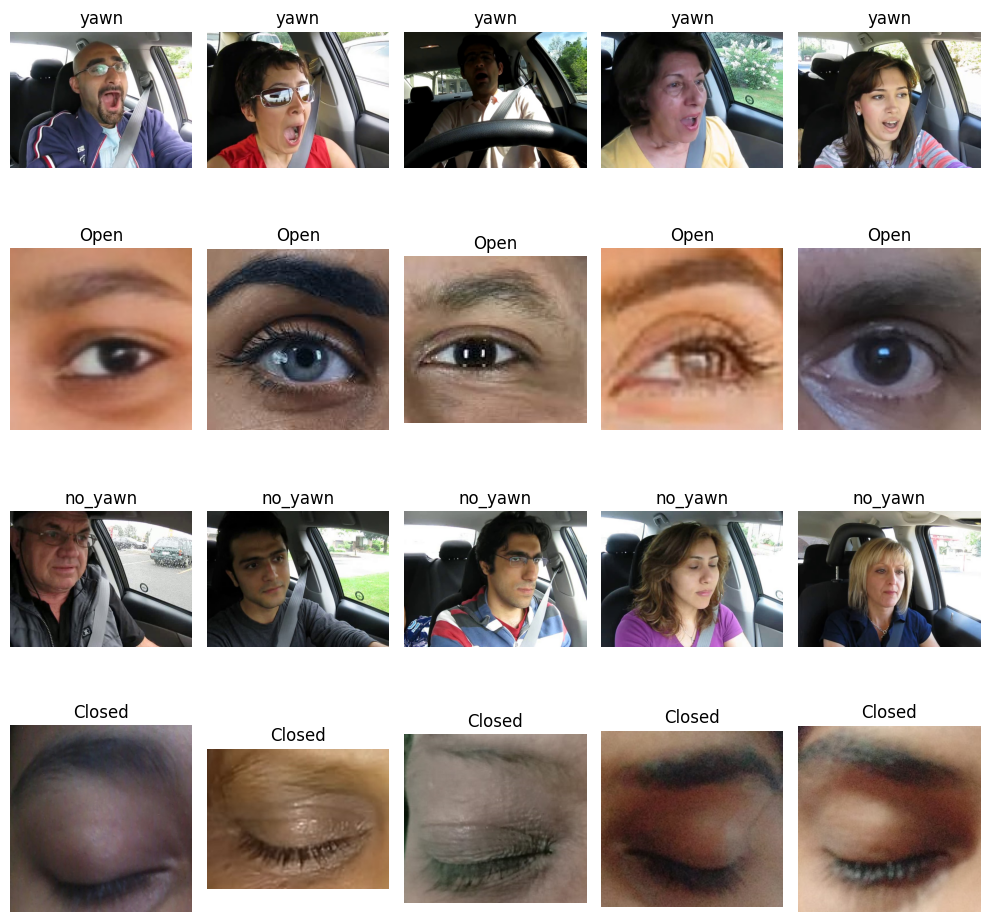

In [ ]:
def plot_sample_images(dataset_path, categories, samples_per_class=5):
    plt.figure(figsize=(10, 10))
    for i, category in enumerate(categories):
        images = os.listdir(os.path.join(dataset_path, category))
        random_images = np.random.choice(images, size=samples_per_class, replace=False)
        for j, img in enumerate(random_images):
            img_path = os.path.join(dataset_path, category, img)
            plt.subplot(len(categories), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(Image.open(img_path))
            plt.axis('off')
            plt.title(category)
    plt.tight_layout()
    plt.show()

plot_sample_images(dataset_path, categories)

## Image dimension

In [ ]:
def get_image_dimensions(dataset_path, categories):
    dimensions = []
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for image in os.listdir(category_path):
            img_path = os.path.join(category_path, image)
            with Image.open(img_path) as img:
                dimensions.append(img.size)
    return dimensions

dataset_path = 'dataset_new/train'
categories = os.listdir(dataset_path)

image_dimensions = get_image_dimensions(dataset_path, categories)

dimension_df = pd.DataFrame(image_dimensions, columns=['Width', 'Height'])

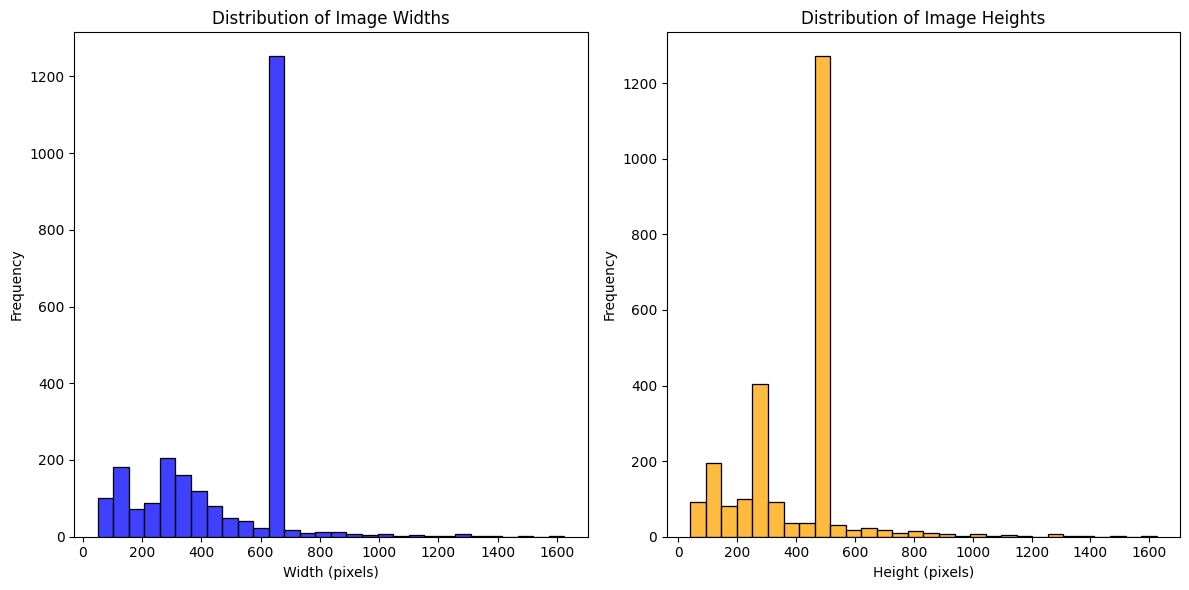

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(dimension_df['Width'], bins=30, color='blue')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(dimension_df['Height'], bins=30, color='orange')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

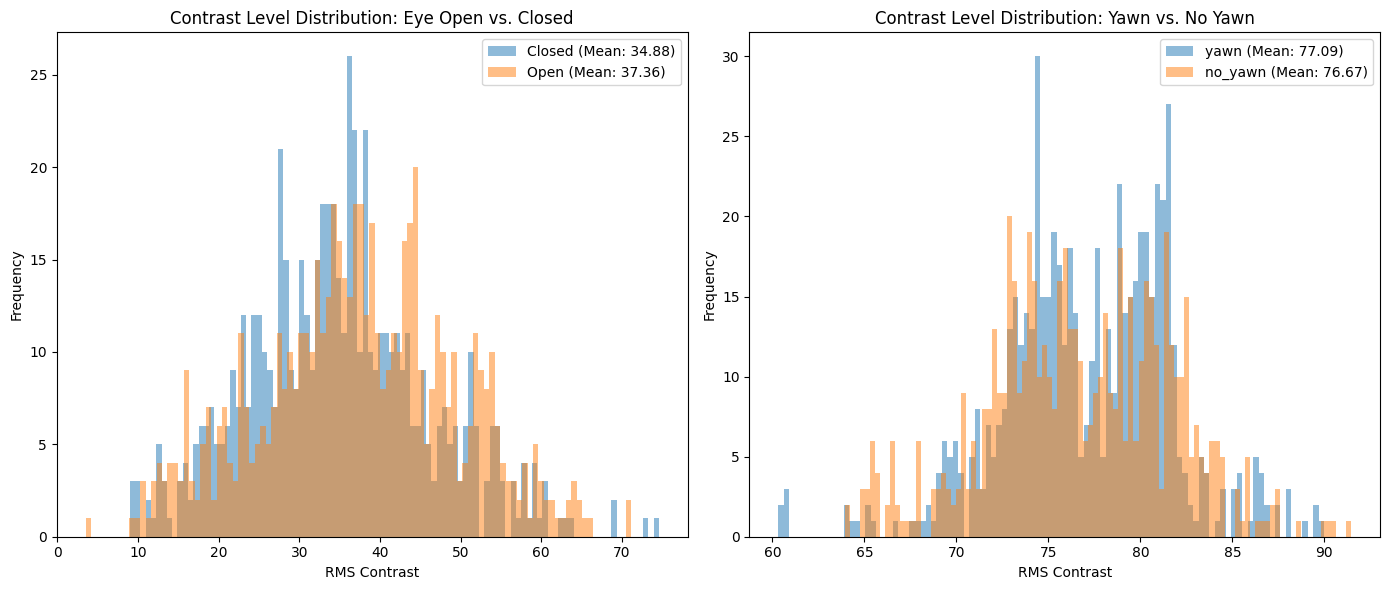

In [ ]:
def calculate_rms_contrast(img):
    """Calculate RMS contrast for a given image."""
    gray_img = img.convert("L")
    pixel_values = np.array(gray_img).flatten()
    mean_intensity = np.mean(pixel_values)
    rms_contrast = np.sqrt(np.mean((pixel_values - mean_intensity) ** 2))
    return rms_contrast

def get_contrast_levels(dataset_path, categories):
    """Calculate RMS contrast for all images in each category."""
    contrast_data = {category: [] for category in categories}

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)

        for image_name in images:
            img_path = os.path.join(category_path, image_name)
            with Image.open(img_path) as img:
                contrast = calculate_rms_contrast(img)
                contrast_data[category].append(contrast)

    return contrast_data

dataset_path = 'dataset_new/train'

eye_categories = ['Closed', 'Open']
yawn_categories = ['yawn', 'no_yawn']

eye_contrast = get_contrast_levels(dataset_path, eye_categories)
yawn_contrast = get_contrast_levels(dataset_path, yawn_categories)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for category, contrasts in eye_contrast.items():
    plt.hist(contrasts, bins=100, alpha=0.5, label=f'{category} (Mean: {np.mean(contrasts):.2f})')
plt.xlabel('RMS Contrast')
plt.ylabel('Frequency')
plt.title('Contrast Level Distribution: Eye Open vs. Closed')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
for category, contrasts in yawn_contrast.items():
    plt.hist(contrasts, bins=100, alpha=0.5, label=f'{category} (Mean: {np.mean(contrasts):.2f})')
plt.xlabel('RMS Contrast')
plt.ylabel('Frequency')
plt.title('Contrast Level Distribution: Yawn vs. No Yawn')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Baseline model

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_new/train',
    seed = 41,
    shuffle = True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 2467 files belonging to 4 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)

['Closed', 'Open', 'no_yawn', 'yawn']


In [ ]:
def get_split_data(ds, train_split=0.8, test_splt=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_splt + val_split ) == 1
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)

        return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_split_data(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=10,
    callbacks=callback)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 386s 6s/step - accuracy: 0.5531 - loss: 0.9615 - val_accuracy: 0.5893 - val_loss: 1.0713
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 358s 6s/step - accuracy: 0.7201 - loss: 0.6037 - val_accuracy: 0.7455 - val_loss: 0.6167
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step - accuracy: 0.7247 - loss: 0.5834 - val_accuracy: 0.7857 - val_loss: 0.4913
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 359s 6s/step - accuracy: 0.7316 - loss: 0.5149 - val_accuracy: 0.7545 - val_loss: 0.4083
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 359s 6s/step - accuracy: 0.7680 - loss: 0.4658 - val_accuracy: 0.7411 - val_loss: 0.5113
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 358s 6s/step - accuracy: 0.7770 - loss: 0.4387 - val_accuracy: 0.7946 - val_loss: 0.4357
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 358s 6s/step - accuracy: 0.7738 - loss: 0.4310 - val_accuracy: 0.7991 - val_loss: 0.3785
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 359s 6s/step - accuracy: 0.7598 - loss: 0.4368 - val_accuracy: 0.7812 - v

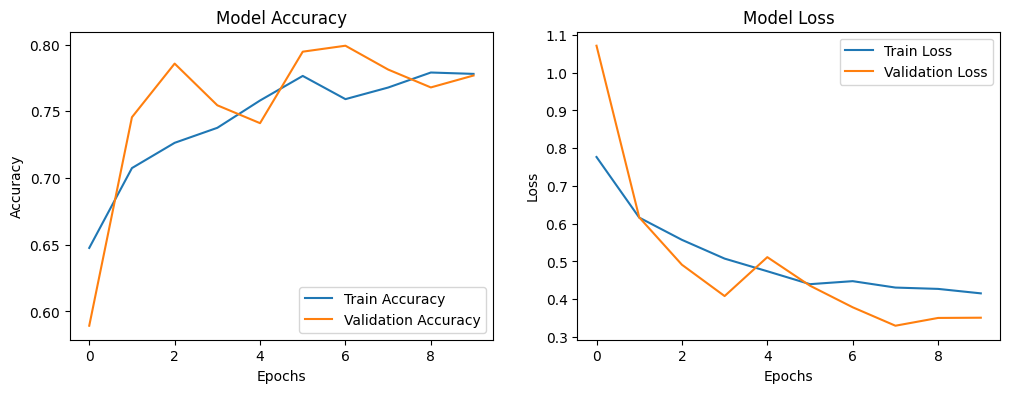

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
               precision    recall  f1-score   support

      Closed       0.99      0.87      0.93        78
        Open       0.88      0.97      0.92        68
     no_yawn       0.60      0.37      0.46        73
        yawn       0.53      0.75      0.62        69

    accuracy                           0.74       288
   macro avg       0.75      0.74      0.73       288
weighted avg       0.75      0.74      0.73       288



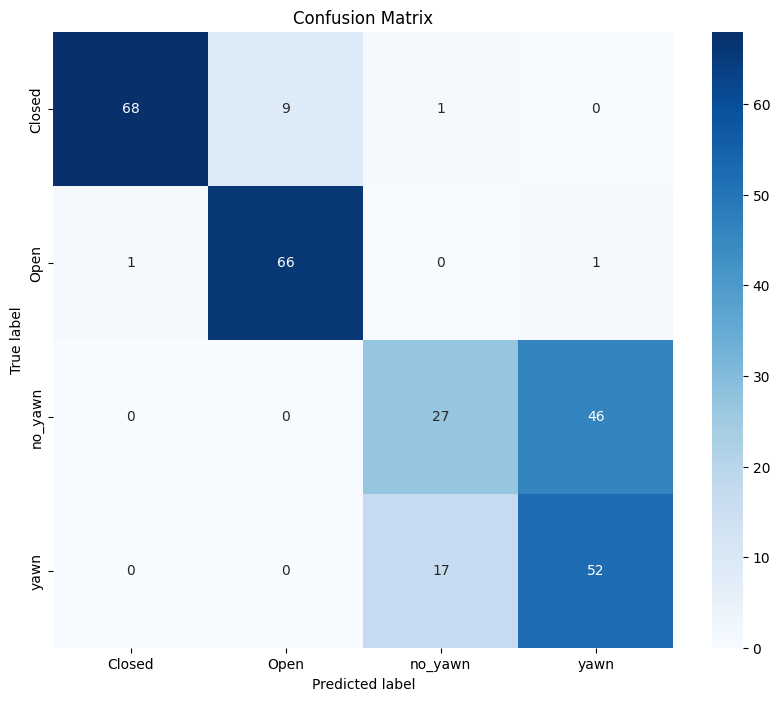

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting on the test set
y_true = []
y_pred = []

# Loop through the test dataset and collect true labels and predicted labels
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)

# Print classification report
print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Transfer Learning with Inception V3

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

# Define constants
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNELS = 3
n_classes = 4

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'dataset_new/train',
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Split the dataset
def get_split_data(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_split_data(dataset)

# Cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load InceptionV3 as base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Set up early stopping
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[callback]
)

Found 2467 files belonging to 4 classes.
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 415s 6s/step - accuracy: 0.5844 - loss: 0.9313 - val_accuracy: 0.7455 - val_loss: 0.5666
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 388s 6s/step - accuracy: 0.7358 - loss: 0.5802 - val_accuracy: 0.7500 - val_loss: 0.4803
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 382s 6s/step - accuracy: 0.7655 - loss: 0.4965 - val_accuracy: 0.7857 - val_loss: 0.4462
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 381s 6s/step - accuracy: 0.7948 - loss: 0.4433 - val_accuracy: 0.7500 - val_loss: 0.4506
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 384s 6s/step - accuracy: 0.7941 - loss: 0.4546 - val_accuracy: 0.7455 - val_loss: 0.4462
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.7849 - loss: 0.4793 - val_accuracy: 0.7009 - val_loss: 0.5086
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 384s 6s/step - accuracy: 0.8101 - loss: 0.4441 - val_accuracy: 0.7768 - val_loss: 0.4447
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.8153 

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Classification Report:
               precision    recall  f1-score   support

      Closed       0.85      0.97      0.90        63
        Open       0.97      0.87      0.92        87
     no_yawn       0.61      0.97      0.75        68
        yawn       0.93      0.39      0.55        70

    accuracy                           0.80       288
   macro avg       0.84      0.80      0.78       288
weighted avg       0.85      0.80      0.78       288



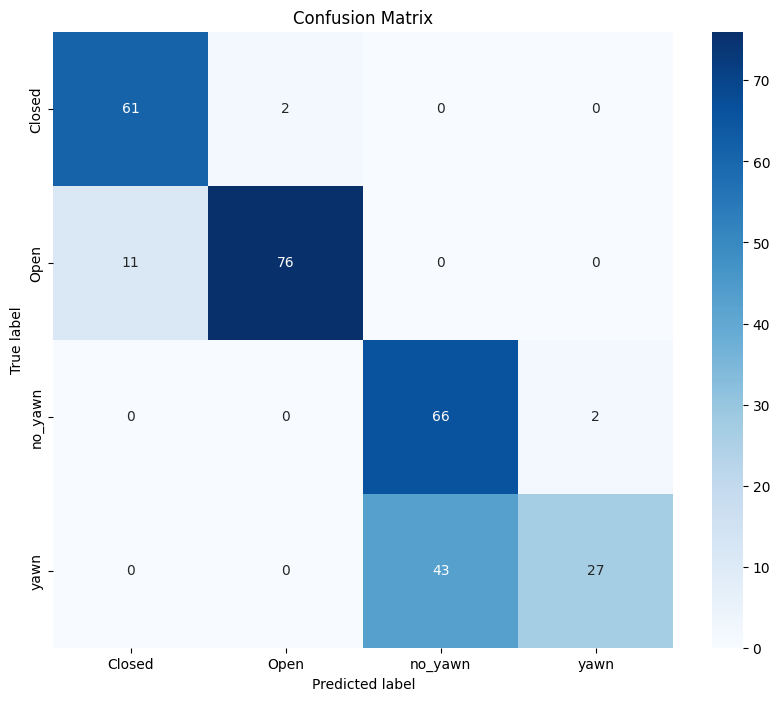

In [ ]:
# Predictions and evaluation on the test set
y_true = []
y_pred = []
confidence_scores = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    confidence_scores_batch = np.max(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)
    confidence_scores.extend(confidence_scores_batch)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_scores = np.array(confidence_scores)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:\n", class_report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

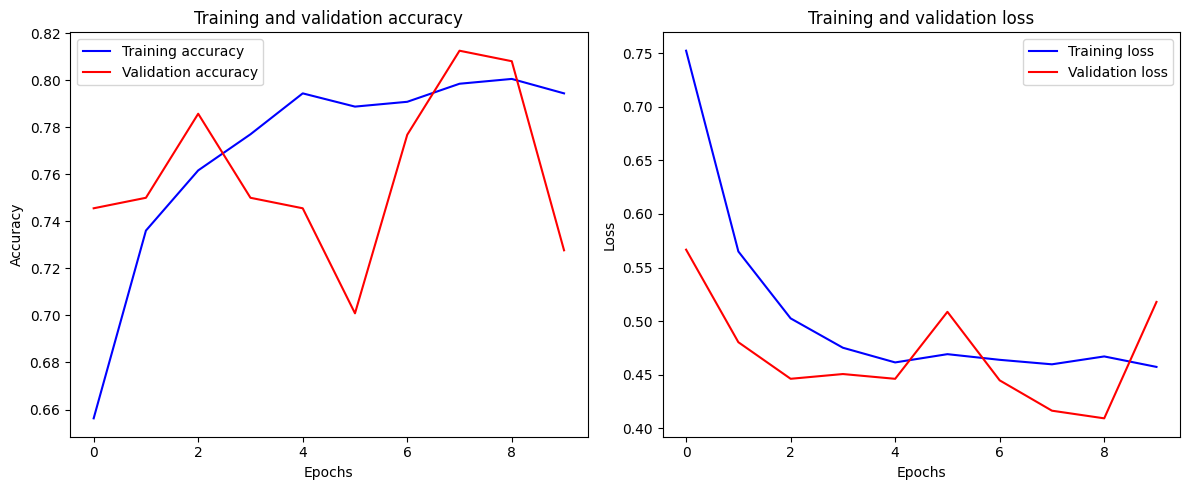

In [ ]:
def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))  # Get number of epochs

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Discussion

## Data preprocessing using Facial detection to crop images in yawn and no yawn images

In [ ]:
import cv2

In [ ]:
import numpy as np
import os
import cv2

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def norm_yawn(data_directory='dataset_new/train'):
    yawn_norm_images = []
    yawn_norm_labels = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]

    no_face_count = 0  # Counter for images with no detected faces

    for category in categories:
        path_link = os.path.join(data_directory, category)
        class_num = categories.index(category)
        print(f"Processing category: {category}, class number: {class_num}")

        for image in os.listdir(path_link):
            image_path = os.path.join(path_link, image)
            image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if image_array is None:
                print(f"Could not read image {image}")
                continue  # Skip if image could not be read

            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

            if len(faces) == 0:
                no_face_count += 1  # Increment counter for images without faces

            for (x, y, w, h) in faces:
                roi_color = image_array[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yawn_norm_images.append(resized_array)
                yawn_norm_labels.append(class_num)

    print(f"Total images with no detected faces: {no_face_count}")

    return yawn_norm_images, yawn_norm_labels

def norm_eye(data_directory='dataset_new/train'):
    eye_norm_images = []
    eye_norm_labels = []
    IMAGE_SIZE = 145
    eye_labels = ['Closed', 'Open']
    for eye_label in eye_labels:
        category_path = os.path.join(data_directory, eye_label)
        class_number = eye_labels.index(eye_label) + 2
        print(f"Processing category: {eye_label}, class number: {class_number}")
        for img_file in os.listdir(category_path):
            try:
                img_array = cv2.imread(os.path.join(category_path, img_file), cv2.IMREAD_COLOR)
                resized_image = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
                eye_norm_images.append(resized_image)
                eye_norm_labels.append(class_number)
            except Exception as e:
                print(e)
    return eye_norm_images, eye_norm_labels

Preprocess training data

In [ ]:
data_directory = 'dataset_new/train'
yawn_train_images, yawn_train_labels = norm_yawn(data_directory=data_directory)

eye_train_images, eye_train_labels = norm_eye()

# Combine the data
X_train = np.array(yawn_train_images + eye_train_images)
y_train = np.array(yawn_train_labels + eye_train_labels)

print(f'Images shape: {X_train.shape}, Labels shape: {y_train.shape}')

Processing category: yawn, class number: 0
Processing category: no_yawn, class number: 1
Total images with no detected faces: 828
Processing category: Closed, class number: 2
Processing category: Open, class number: 3
Images shape: (1644, 145, 145, 3), Labels shape: (1644,)


In [ ]:
data_directory = 'dataset_new/test'
yawn_test_images, yawn_test_labels = norm_yawn(data_directory=data_directory)

eye_test_images, eye_test_labels = norm_eye()

# Combine the data
X_test = np.array(yawn_test_images + eye_test_images)
y_test = np.array(yawn_test_labels + eye_test_labels)

print(f'Images shape: {X_test.shape}, Labels shape: {y_test.shape}')

Processing category: yawn, class number: 0
Processing category: no_yawn, class number: 1
Total images with no detected faces: 153
Processing category: Closed, class number: 2
Processing category: Open, class number: 3
Images shape: (1297, 145, 145, 3), Labels shape: (1297,)


Yawn Data Samples:


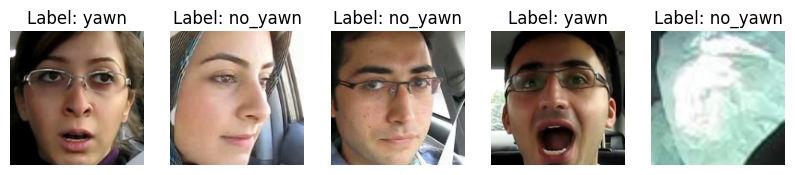

Eye Data Samples:


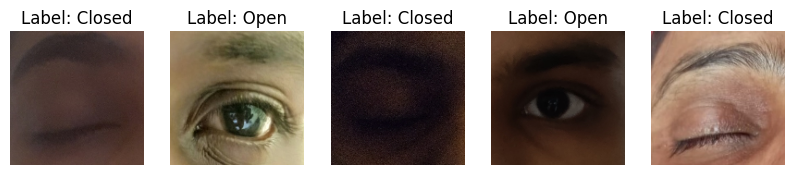

In [ ]:
# Check if lables are mapping correctly

# Helper function to map labels to category names
def get_category_name(label, yawn_categories, eye_categories):
    if label in [0, 1]:
        return yawn_categories[label]
    elif label in [2, 3]:
        return eye_categories[label - 2]  # Shift index for eye categories

def show_samples(images, labels, yawn_categories, eye_categories, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        category_name = get_category_name(labels[idx], yawn_categories, eye_categories)

        # Convert BGR to RGB if needed (for OpenCV-loaded images)
        img_rgb = images[idx][..., ::-1]  # Swap channels from BGR to RGB

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img_rgb)
        plt.title(f'Label: {category_name}')
        plt.axis('off')
    plt.show()

# Define categories
yawn_categories = ["yawn", "no_yawn"]
eye_categories = ["Closed", "Open"]

# Show some sample yawn images
print("Yawn Data Samples:")
show_samples(yawn_train_images, yawn_train_labels, yawn_categories, eye_categories)

# Show some sample eye images
print("Eye Data Samples:")
show_samples(eye_train_images, eye_train_labels, yawn_categories, eye_categories)

## Roboflow and Yolo

https://universe.roboflow.com/sleep-lnkl2/sleep-k3d5a


In [ ]:
pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [ ]:
pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 8.0 MB/s eta 0:00:00


In [ ]:
pip install inference-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.0 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


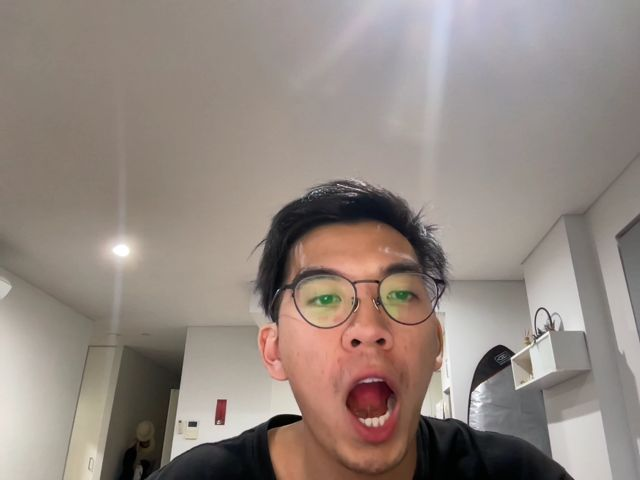

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="e2T6T1PRmwwyqOhieqjN"
)

result = CLIENT.infer("photo.jpg", model_id="sleep-k3d5a/6")

In [ ]:
print(result)

{'inference_id': '4212beaf-7cb5-4292-9034-2825a4fd2695', 'time': 0.03567200700035755, 'image': {'width': 640, 'height': 480}, 'predictions': [{'x': 370.5, 'y': 403.0, 'width': 81.0, 'height': 86.0, 'confidence': 0.6942291259765625, 'class': 'Yawn', 'class_id': 0, 'detection_id': '244622e8-4db2-4e52-b6b9-a14db1a78384'}]}


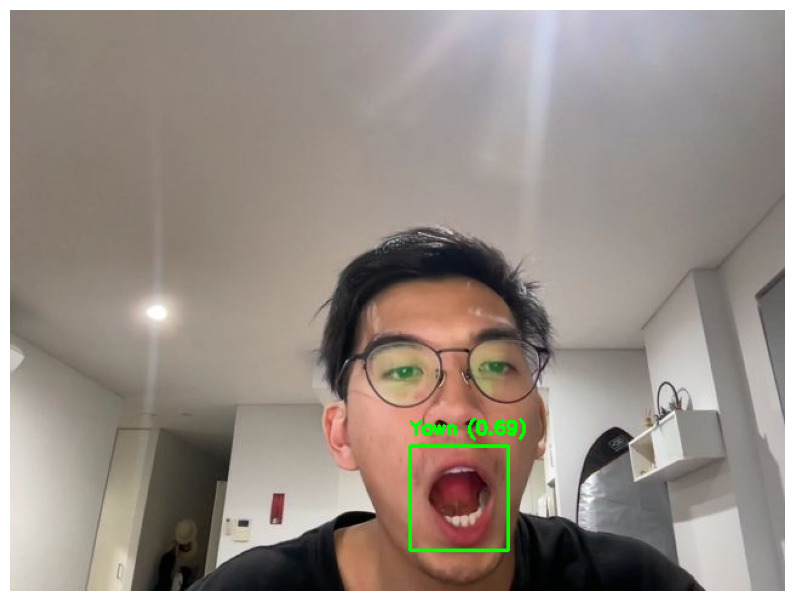

In [ ]:
# Load the original image using OpenCV
image = cv2.imread("photo.jpg")

# Extract predictions from the result
for prediction in result["predictions"]:
    # Get bounding box coordinates and label
    x, y, width, height = prediction["x"], prediction["y"], prediction["width"], prediction["height"]
    class_name = prediction["class"]
    confidence = prediction["confidence"]

    # Convert (x, y, width, height) to (x_min, y_min, x_max, y_max)
    x_min = int(x - width / 2)
    y_min = int(y - height / 2)
    x_max = int(x + width / 2)
    y_max = int(y + height / 2)

    # Draw bounding box on the image
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Display class label and confidence
    label = f"{class_name} ({confidence:.2f})"
    cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert the image from BGR to RGB for Matplotlib display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes for better visualization
plt.show()